### Modelo preditivo Dai

- Instalar biblioteca **yfinance**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 12.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


- Importar bibliotecas de manipulação de dados

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

- Importar bibliotecas realizar as predições

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

- Importar bibliotecas para plotar gráficos

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

- Importar bibliotecas internas do python

In [ ]:
from functools import reduce
from datetime import datetime

- Definir datas para capturar os dados

In [ ]:
date_today = datetime.strftime(datetime.today(), '%Y-%m-%d')
date_init = "2014-01-01"

- Criar funções auxiliares 

In [ ]:
TICKER = "DAI-USD"

def download_tickers(ticker):
  try:
    asset = yf.download(ticker, start=date_init, end=date_today, interval='1d')
    return asset.Close
  except Exception as err:
    print(f"ERROR: {err}")

  
def create_data_frame(asset_close, ticker):
  return pd.DataFrame(asset_close).rename(columns = {'Close': ticker})


def mean_absolute_percentage_error(y_true, y_pred):
	"""Take in true and predicted values and calculate the MAPE score"""
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Download dos dados

In [ ]:
df_dai = yf.download(TICKER, date_init, date_today)
df_dai = df_dai.reset_index()

[*********************100%***********************]  1 of 1 completed


- Reindexar index, por default vem o Date

In [ ]:
df_dai.reset_index(inplace=True)

In [ ]:
df_dai.dtypes

index                      int64
Date         datetime64[ns, UTC]
Open                     float64
High                     float64
Low                      float64
Close                    float64
Adj Close                float64
Volume                     int64
dtype: object

- Converter data

In [ ]:
df_dai['Date'] = pd.to_datetime(df_dai['Date'], format="%Y-%m-%d")

- Criar médias móveis de 7 dias e 21 dias

In [ ]:
df_dai['mm7d'] = df_dai['Adj Close'].rolling(7).mean()
df_dai['mm21d'] = df_dai['Adj Close'].rolling(21).mean()

df_dai.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
1053,1053,2022-10-10 00:00:00+00:00,0.999880,1.000513,0.998571,0.999256,0.999256,240484178,0.999655,0.999735
1054,1054,2022-10-11 00:00:00+00:00,0.999239,1.000325,0.998652,0.999690,0.999690,357029174,0.999627,0.999746
1055,1055,2022-10-12 00:00:00+00:00,0.999690,1.000296,0.999226,0.999299,0.999299,234673316,0.999575,0.999710
1056,1056,2022-10-13 00:00:00+00:00,0.999245,1.001039,0.998376,0.999643,0.999643,595469371,0.999595,0.999708
1057,1057,2022-10-14 00:00:00+00:00,0.999657,1.001533,0.998722,1.000116,1.000116,450740086,0.999665,0.999708


- Função de agrupamento dos dados

In [ ]:
def group_data(type_group):
  new_df = df_dai.groupby(pd.Grouper(key="Date", freq=type_group)).sum()
  new_df.reset_index(inplace=True)
  return new_df

- Função para plotar grafico conforme o Agrupamento dos Dados
- Tipo de agrupamento:
- Por Meses (M) ou por Semanas (W)
- Por Ano (year)
- Tipo de grafico: 'bar',  'line',  'hist',  'barh'

In [ ]:
def create_plot_custom(filter_Mounth_or_Week, year, type_plot):
  """ 
    Cria um grafico filtrando por Ano, Meses ou Semanas

    filter_Mounth_or_Week: 'M' ou 'W'
    type_plot: 'line', 'bar', 'hist', 'barh'
  
  """
  if year >= 2014 and year <= 2022 and filter_Mounth_or_Week in ("M", "W"):
    filtro_label = None
    df_filter = group_data(filter_Mounth_or_Week)
    include = df_filter[df_filter['Date'].dt.year == year]
    meses = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    if len(include.index) <= 12:
      include.index = meses[:len(include.index)]
      filtro_label = "Meses"
    elif len(include.index) > 50:
      include.index = [i for i in range(0, len(include.index))]
      filtro_label = "Semanas"
    include.plot(y="Adj Close", kind=type_plot, figsize=(14, 8),rot=30, title=f'Distruibuição por {filtro_label} - ano {year}', ylabel='Preço US$', xlabel=filtro_label, color="blue")

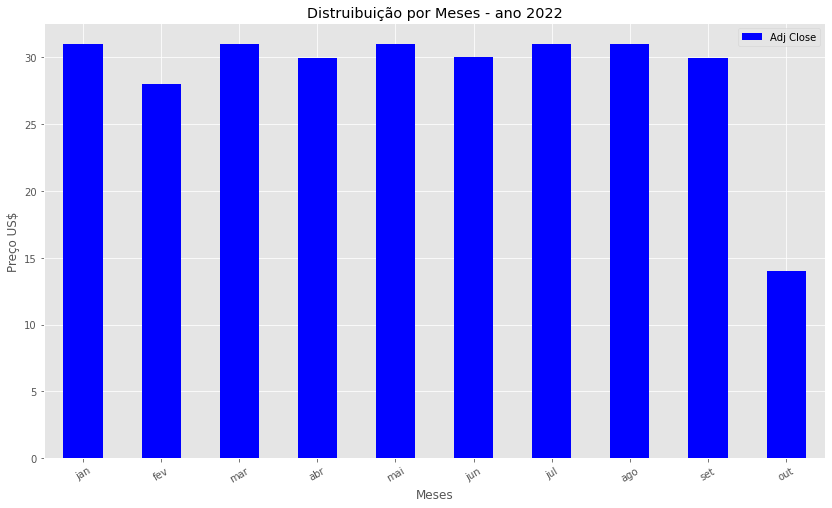

In [ ]:
create_plot_custom("M", 2022, "bar")

- Empurrando para frente os valores da criptomoeda

In [ ]:
df_dai['Adj Close'] = df_dai['Adj Close'].shift(-1)
df_dai.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
1053,1053,2022-10-10 00:00:00+00:00,0.999880,1.000513,0.998571,0.999256,0.999690,240484178,0.999655,0.999735
1054,1054,2022-10-11 00:00:00+00:00,0.999239,1.000325,0.998652,0.999690,0.999299,357029174,0.999627,0.999746
1055,1055,2022-10-12 00:00:00+00:00,0.999690,1.000296,0.999226,0.999299,0.999643,234673316,0.999575,0.999710
1056,1056,2022-10-13 00:00:00+00:00,0.999245,1.001039,0.998376,0.999643,1.000116,595469371,0.999595,0.999708
1057,1057,2022-10-14 00:00:00+00:00,0.999657,1.001533,0.998722,1.000116,NaN,450740086,0.999665,0.999708


- Remover os dados nulos

In [ ]:
df_dai.dropna(inplace=True)
df_dai

,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
20,20,2019-12-12 00:00:00+00:00,1.003136,1.010460,0.996499,1.005456,1.003854,2372303,1.004303,1.003890
21,21,2019-12-13 00:00:00+00:00,1.005864,1.007776,0.999520,1.003854,1.007594,2211492,1.004582,1.004426
22,22,2019-12-14 00:00:00+00:00,1.003283,1.009757,1.001476,1.007594,1.003221,1645619,1.004840,1.004012
23,23,2019-12-15 00:00:00+00:00,1.007594,1.010131,0.981594,1.003221,1.006222,1505775,1.004777,1.004057
24,24,2019-12-16 00:00:00+00:00,1.003221,1.022722,0.999106,1.006222,1.000816,3403102,1.004747,1.004019
...,...,...,...,...,...,...,...,...,...,...
1052,1052,2022-10-09 00:00:00+00:00,0.999911,1.000236,0.999096,0.999886,0.999256,183634481,0.999770,0.999739
1053,1053,2022-10-10 00:00:00+00:00,0.999880,1.000513,0.998571,0.999256,0.999690,240484178,0.999655,0.999735
1054,1054,2022-10-11 00:00:00+00:00,0.999239,1.000325,0.998652,0.999690,0.999299,357029174,0.999627,0.999746
1055,1055,2022-10-12 00:00:00+00:00,0.999690,1.000296,0.999226,0.999299,0.999643,234673316,0.999575,0.999710


- Testar se o DataFrame possui dados nulos

In [ ]:
assert df_dai.isnull().sum().sum() == 0

- Separar os dados em Treino, Teste e Validação. 

In [ ]:
qtd_linhas = len(df_dai)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:726 linhas teste= 726:1036 linhas validação= 1036'

- Separar a **labels** que será o target a ser encontrado pelo modelo preditivo
- Separar as **features** que serão utilizadas para prever o valor final

In [ ]:
features = df_dai.drop(['Date', 'Adj Close'], 1)
labels = df_dai['Adj Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


- Escolhendo as melhores features com Kbest

In [ ]:
features_list = ('Date', 'Open', 'High', 'Low', 'Volume', 'mm7d', 'mm21d')

selector = SelectKBest(score_func=f_regression, k='all').fit(features, labels)
x_new = selector.transform(features)
scores = selector.scores_

raw_pairs = zip(features_list[1:], scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print("Melhores features:")
print(k_best_features_final)

Melhores features:
{'mm7d': 372.5111423457892, 'High': 273.0927935658657, 'Open': 149.4796681358227, 'mm21d': 87.78607348034888, 'Volume': 69.97653505713235, 'Low': 4.965566275814661}


- Separando as features escolhidas, com melhor pontuação

In [ ]:
features = df_dai.loc[:,['mm7d','High', 'Open']]
features

,mm7d,High,Open
20,1.004303,1.010460,1.003136
21,1.004582,1.007776,1.005864
22,1.004840,1.009757,1.003283
23,1.004777,1.010131,1.007594
24,1.004747,1.022722,1.003221
...,...,...,...
1052,0.999770,1.000236,0.999911
1053,0.999655,1.000513,0.999880
1054,0.999627,1.000325,0.999239
1055,0.999575,1.000296,0.999690


- Criando Pipeline

In [ ]:
pipeline_linear_regression = make_pipeline(MinMaxScaler(), LinearRegression())

- Separa os dados de treino teste e validação

In [ ]:
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

726 726
310 310


- Treina modelo

In [ ]:
pipeline_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

- Confere 

In [ ]:
score_model = pipeline_linear_regression.score(X_test, y_test)
f'Teste pontuação para avaliar a consistência do modelo: {score_model * 100:.2f}%'

'Teste pontuação para avaliar a consistência do modelo: -136.84%'

- Pega último dado do dataframe

In [ ]:
data_pred = ['mm7d','High', 'Open']
df_dai.tail(1)

,index,Date,Open,High,Low,Close,Adj Close,Volume,mm7d,mm21d
1056,1056,2022-10-13 00:00:00+00:00,0.999245,1.001039,0.998376,0.999643,1.000116,595469371,0.999595,0.999708


- Testar a predição

In [ ]:
pipeline_linear_regression.predict(df_dai.tail(1)[data_pred])

array([1.00055812])

- Realizar a predição com os dados de testes(dados que o modelo desconhece)

In [ ]:
previsao = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

data_btc_full=df_dai["Date"]
data_btc = data_btc_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

res_full = df_dai["Adj Close"]
res = res_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]


predict2 = pipeline_linear_regression.predict(previsao)


df = pd.DataFrame({ "data_dai": data_btc, "real": res , "previsao": predict2 })

df["real"] = df["real"].shift(+1)

df.set_index("data_dai", inplace= True)

df.tail()



,real,previsao
data_dai,,
2022-10-08 00:00:00+00:00,0.999763,1.000682
2022-10-09 00:00:00+00:00,0.999886,1.000716
2022-10-10 00:00:00+00:00,0.999256,1.000630
2022-10-11 00:00:00+00:00,0.999690,1.000581
2022-10-12 00:00:00+00:00,0.999299,1.000561


- Plotar os resultados

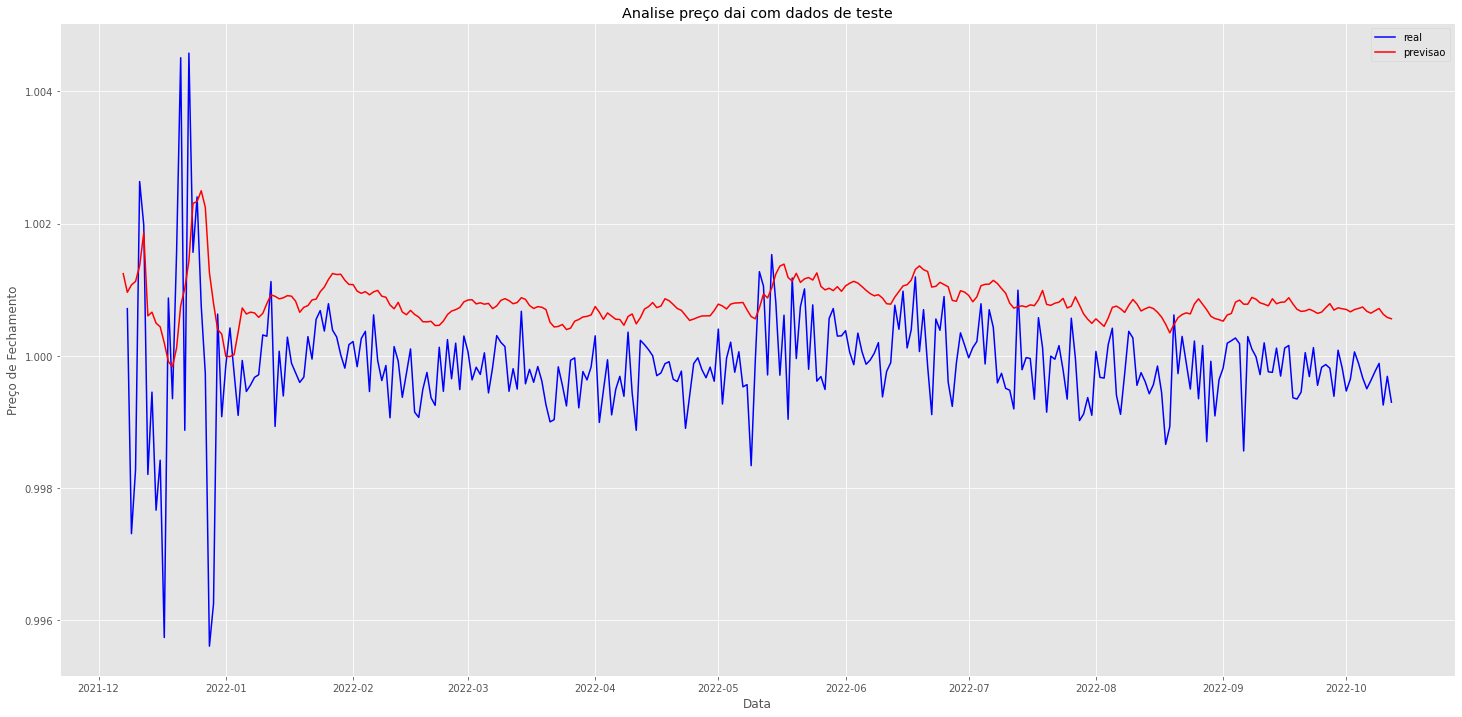

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Analise preço dai com dados de teste")
plt.plot(df["real"], label="real", color="blue")
plt.plot(df["previsao"], label="previsao", color="red")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
leg = plt.legend()

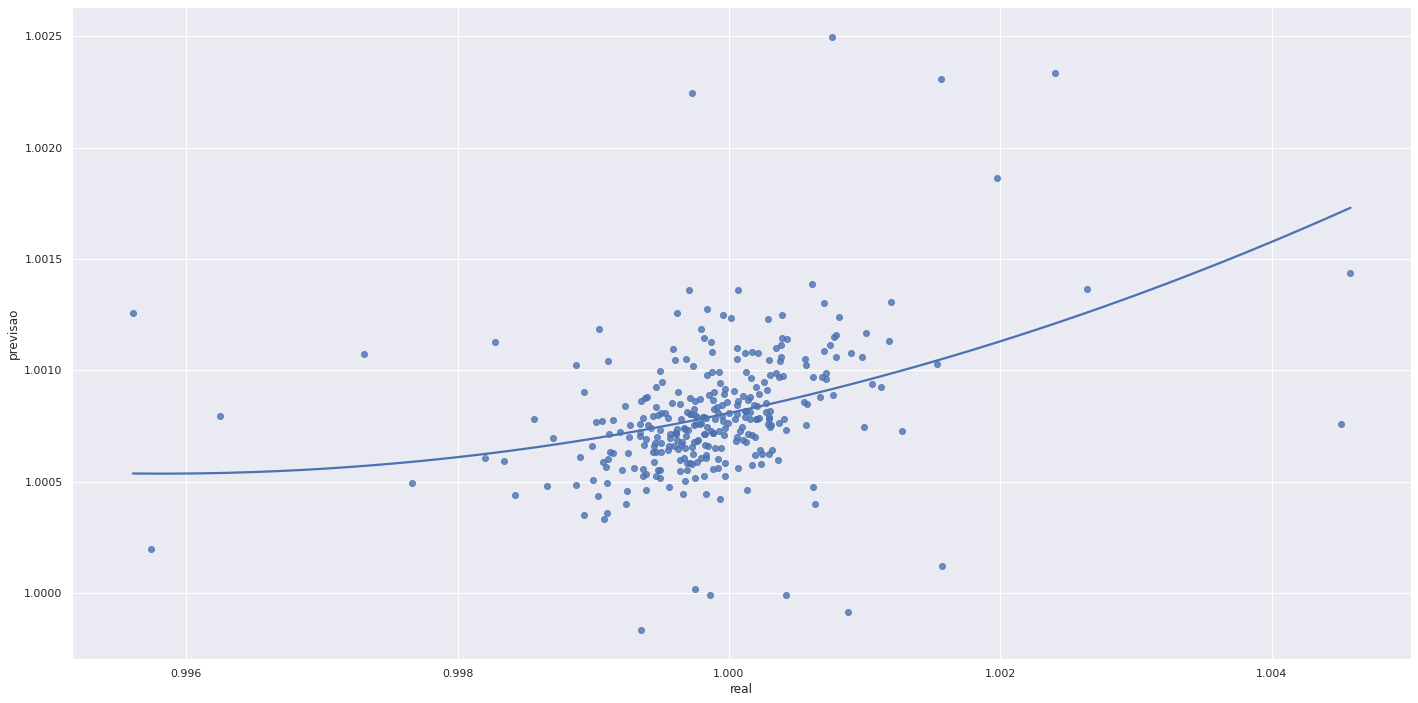

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(24, 12)})
sns.regplot(x ="real", y ="previsao", data = df, ci=False, order=2)

- Export modelo preditivo 

In [ ]:
joblib.dump(pipeline_linear_regression, 'pipeline_linear_regression.pk1')

['pipeline_linear_regression.pk1']

- Import modelo preditivo

In [ ]:
model = joblib.load('pipeline_linear_regression.pkl')